## Notebook to compare GOES X-ray flare lists 

There are several ways to access the GOES flare list, and this notebook aims to query them all and inspect the differences.

There ways to access the GOES flare list are:

* NGDC yearly event files from (https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/x-rays/goes/xrs/) available from 1975-2016.

* Daily SWPC event reports (available to present)

* Query the HEK with the `frm_name==SWPC` attr

* From HELIO (http://voparis-helio.obspm.fr/hec/stfc/HEC_ListsAll.html)

* From the IDL GOES workbench which using `rd_gev.pro`. 

This notebook aims to search over past solar cycle 2010-2018.

In [1]:
import urllib
import pandas as pd 
from sunpy.time import TimeRange
from flarelist_utils import read_swpc_reports, read_ngdc_goes_reports
from dateutil.relativedelta import relativedelta
import pandas as pd 
import numpy as np
import datetime
import glob
import h5netcdf
import matplotlib.pyplot as plt
from scipy.io import readsav
from sunpy.time import parse_time
from matplotlib import dates
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Helvetica'

## GEV flare list

Lets look at the flares from the GOES IDL workbench

```
a = ogoes()
gev = a->get_gev('01-Jan-2010', '31-Dec-2018', /struct)
save, gev, filename="goes_flares_from_idl.sav"
```

In [2]:
gev_data = readsav("goes_flares_from_idl.sav")["gev"]
gev_dict = {k : gev_data[k].astype(str) for k in gev_data.dtype.names}; gev_df = pd.DataFrame(gev_dict)

gev_df["goes_class_ind"] = [x[0] for x in gev_df["CLASS"]]
gev_df["datetime"] = pd.to_datetime(gev_df["GSTART"])
gev_df_c = gev_df[gev_df["goes_class_ind"].isin(["C", "M", "X"])]

gev_df_c = gev_df_c.drop_duplicates(subset="datetime")
gev_df_c["match_time"] = gev_df_c.datetime.dt.strftime("%Y-%m-%d %H:%M")
gev_df_c["unique_month"] = pd.to_datetime(gev_df_c.datetime.dt.strftime("%Y-%m"))
gev_df_c["unique_day"] = pd.to_datetime(gev_df_c.datetime.dt.strftime("%Y-%m-%d"))

gev_df_c = gev_df_c.set_index("datetime")

<AxesSubplot:xlabel='unique_day'>

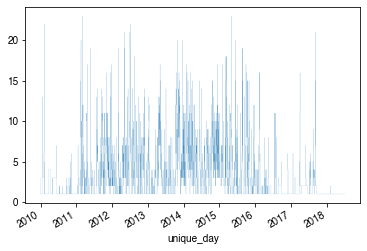

In [3]:
gev_df_c.groupby("unique_day")["goes_class_ind"].count().plot(drawstyle="steps-mid", lw=0.1)

## SWPC flare list 

Flare list from daily reports. `swpc_event_list.csv` was created by searching each daily file between 2010-01-01 to 2018-12-31 and merging together into one csv file for flares >= C1.

In [4]:
swpc_flares = pd.read_csv("swpc_event_list.csv")
swpc_flares["datetime"] = pd.to_datetime(swpc_flares.ts, format="%Y%m%d%H%M")
swpc_flares["unique_month"] = pd.to_datetime(swpc_flares.datetime.dt.strftime("%Y-%m"))
swpc_flares["unique_day"] = pd.to_datetime(swpc_flares.datetime.dt.strftime("%Y-%m-%d"))
swpc_flares = swpc_flares.set_index("datetime")

In [25]:
np.sum(swpc_flares["noaa_ar"].isin(['     ']))/len(swpc_flares)

0.10887752730653033

## HEK flares

Flare list by querying the HEK for flares from `a.hek.OBS.Observatory == "GOES"`
This was performed in another notebook.

In [5]:
hek_flares_all = pd.read_csv("solar_cycle24_flares.csv")

In [6]:
hek_flares_all["goes_class_ind"] = [x[0] for x in hek_flares_all["fl_goescls"]]
hek_flares_all["datetime"] = pd.to_datetime(hek_flares_all["event_starttime"])
hek_flares = hek_flares_all[hek_flares_all["goes_class_ind"].isin(["X", "M", "C"])]

hek_flares = hek_flares[(hek_flares.datetime>="2010-01-01")&(hek_flares.datetime<="2018-12-31")]
hek_flares = hek_flares.drop_duplicates(subset="event_starttime")
hek_flares.reset_index(drop=True, inplace=True)

hek_flares["unique_month"] = pd.to_datetime(hek_flares.datetime.dt.strftime("%Y-%m"))
hek_flares["unique_day"] = pd.to_datetime(hek_flares.datetime.dt.strftime("%Y-%m-%d"))

hek_flares = hek_flares.set_index("datetime")

In [7]:
hek_flares.tail()

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_class_ind,unique_month,unique_day
datetime,,,,,,,,
2018-05-23 18:03:00,2018-05-23T18:03:00,2018-05-23T18:21:00,2018-05-23T18:33:00,C2.0,12712,C,2018-05-01,2018-05-23
2018-05-28 17:04:00,2018-05-28T17:04:00,2018-05-28T17:10:00,2018-05-28T17:12:00,C2.7,12712,C,2018-05-01,2018-05-28
2018-06-06 10:44:00,2018-06-06T10:44:00,2018-06-06T11:00:00,2018-06-06T11:06:00,C1.0,12712,C,2018-06-01,2018-06-06
2018-06-21 01:09:00,2018-06-21T01:09:00,2018-06-21T01:15:00,2018-06-21T01:18:00,C2.1,12715,C,2018-06-01,2018-06-21
2018-07-06 19:41:00,2018-07-06T19:41:00,2018-07-06T20:07:00,2018-07-06T20:42:00,C1.6,0,C,2018-07-01,2018-07-06


This list below was also found by querying the HEK but by using the SWPC observer attrs i.e. `a.hek.FRM.Name`

In [8]:
hek_flares_swpc = pd.read_csv("solar_cycle24_flares_swpc.csv")
hek_flares_swpc["datetime"] = pd.to_datetime(hek_flares_swpc["event_starttime"])
hek_flares_swpc["goes_class_ind"] = [x[0] for x in hek_flares_swpc["fl_goescls"]]
hek_flares_swpc["match_time"] = hek_flares_swpc.datetime.dt.strftime("%Y-%m-%d %H:%M")

hek_flares_swpc["unique_month"] = pd.to_datetime(hek_flares_swpc.datetime.dt.strftime("%Y-%m"))
hek_flares_swpc["unique_day"] = pd.to_datetime(hek_flares_swpc.datetime.dt.strftime("%Y-%m-%d"))

hek_flares_swpc = hek_flares_swpc.set_index("datetime")

## HELIO goes event list

This list is taken from the HELIO database, and created using `helio_flarelist.py`

In [9]:
helio_flarelist = pd.read_csv("helio_flarelist_c.csv")
helio = helio_flarelist[helio_flarelist["goes_class_ind"].isin(["X", "M", "C"])]
helio["datetime"] = pd.to_datetime(helio["time_start"])
helio["match_time"] = helio.datetime.dt.strftime("%Y-%m-%d %H:%M")
helio = helio.drop_duplicates(subset="match_time")

helio["unique_month"] = pd.to_datetime(helio.datetime.dt.strftime("%Y-%m"))
helio["unique_day"] = pd.to_datetime(helio.datetime.dt.strftime("%Y-%m-%d"))

helio = helio.set_index("datetime")

## NOAA NGDC Yearly Files

In [10]:
ngdc_flares = pd.read_csv("merged_ngdc_flarelist.csv")
ngdc_flares["datetime"] = pd.to_datetime(ngdc_flares.match_time)

ngdc_flares["unique_month"] = pd.to_datetime(ngdc_flares.datetime.dt.strftime("%Y-%m"))
ngdc_flares["unique_day"] = pd.to_datetime(ngdc_flares.datetime.dt.strftime("%Y-%m-%d"))

ngdc_flares = ngdc_flares.set_index("datetime")

In [26]:
np.sum(ngdc_flares["noaa_ar"].isnull())/len(ngdc_flares)

0.42411539884108

## Now all data is read in lets analyze number of flares

In [11]:
print("SWPC\n"); print(swpc_flares["goes_class_ind"].value_counts())
print("HELIO\n"); print(helio["goes_class_ind"].value_counts())
print("GEV\n"); print(gev_df_c["goes_class_ind"].value_counts())
print("HEK goes\n"); print(hek_flares["goes_class_ind"].value_counts())
print("HEK swpc\n"); print(hek_flares_swpc["goes_class_ind"].value_counts())
print("NGDC\n"); print(ngdc_flares["goes_class_ind"].value_counts())

SWPC

C    7809
M     748
X      49
Name: goes_class_ind, dtype: int64
HELIO

C    7988
M     735
X      49
Name: goes_class_ind, dtype: int64
GEV

C    7733
M     740
X      49
Name: goes_class_ind, dtype: int64
HEK goes

C    7814
M     756
X      49
Name: goes_class_ind, dtype: int64
HEK swpc

C    7819
M     755
X      49
Name: goes_class_ind, dtype: int64
NGDC

C    7385
M     681
X      45
Name: goes_class_ind, dtype: int64


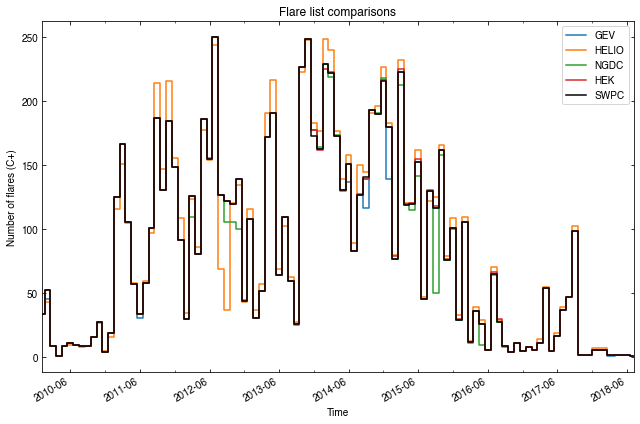

In [65]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9, 6))
gev_df_c.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", axes=ax, label="GEV")

helio.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", axes=ax, label="HELIO")
ngdc_flares.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", axes=ax, label="NGDC")
hek_flares_swpc.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", axes=ax, label="HEK")
swpc_flares.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", axes=ax, label="SWPC", color="k")
plt.legend()
ax.tick_params(which="both", direction="in", top=True, right=True)
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=6))
ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))
ax.set_xlabel("Time")
ax.set_ylabel("Number of flares (C+)")
ax.set_title("Flare list comparisons")
ax.set_xlim("2010-01-01", "2018-07-06")
plt.tight_layout()
plt.savefig("flarelist_comparisons_monthly.png", dpi=300, facecolor="w")

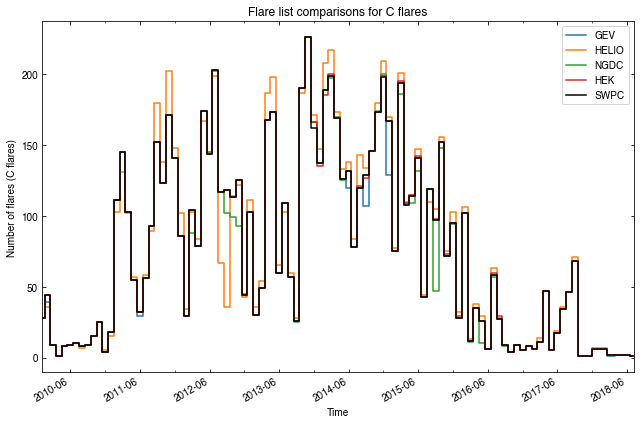

In [55]:
goess = "C"

fig, ax = plt.subplots(figsize=(9, 6))

gev_df_c.groupby("unique_month")["goes_class_ind"].value_counts().unstack()[goess].plot(drawstyle="steps-mid", 
                                                                                        label="GEV", 
                                                                                        color="tab:blue")


helio.groupby("unique_month")["goes_class_ind"].value_counts().unstack()[goess].plot(drawstyle="steps-mid", 
                                                                                     label="HELIO",
                                                                                     color="tab:orange")


ngdc_flares.groupby("unique_month")["goes_class_ind"].value_counts().unstack()[goess].plot(drawstyle="steps-mid", 
                                                                                           label="NGDC",
                                                                                           color="tab:green")

hek_flares_swpc.groupby("unique_month")["goes_class_ind"].value_counts().unstack()[goess].plot(drawstyle="steps-mid", 
                                                                                           label="HEK",
                                                                                           color="tab:red")

swpc_flares.groupby("unique_month")["goes_class_ind"].value_counts().unstack()[goess].plot(drawstyle="steps-mid", 
                                                                                           label="SWPC",
                                                                                           color="k")


plt.legend()
ax.tick_params(which="both", direction="in", top=True, right=True)
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=6))
ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))
ax.set_xlabel("Time")
ax.set_ylabel("Number of flares ({:s} flares)".format(goess))
ax.set_title("Flare list comparisons for {:s} flares".format(goess))
ax.set_xlim("2010-01-01", "2018-07-06")
plt.tight_layout()
plt.savefig("flare_comparisons_{:s}.png".format(goess), dpi=300, facecolor="w")

## Now look at timeseries of flares

In [12]:
def get_goes_class(x):
    if x[0]=="C":
        return float(x[1:])*1e-6
    elif x[0] == "M":
        return float(x[1:])*(1e-5)
    elif x[0] == "X":
        return float(x[1:])*(1e-4)
    elif x[0] == "B":
        return float(x[1:])*(1e-7)
    elif x[0] == "A":
        return float(x[1:])*(1e-8)
    else:
        return

In [13]:
swpc_flares["goes_class_val"] = swpc_flares["goes_class"].map(get_goes_class)
ngdc_flares["goes_class_val"] = ngdc_flares["goes_class"].map(get_goes_class)
gev_df_c["goes_class_val"] = gev_df_c["CLASS"].map(get_goes_class)
hek_flares_swpc["goes_class_val"] = hek_flares_swpc["fl_goescls"].map(get_goes_class)

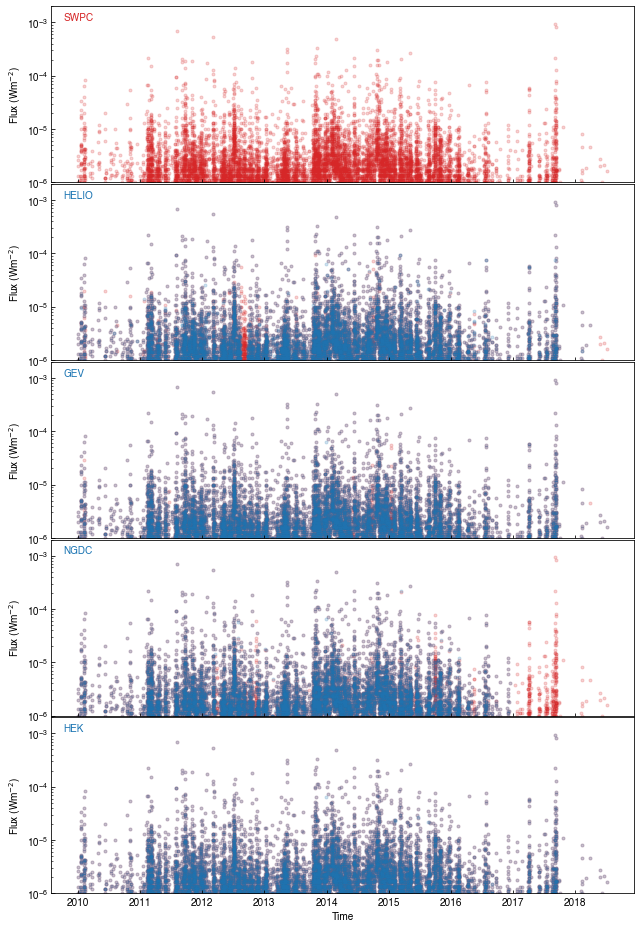

In [137]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, sharey=True, figsize=(9, 13))


ax1.scatter(swpc_flares.index, swpc_flares["goes_class_val"], marker=".", alpha=0.2, color="tab:red")
            #c=np.log10(swpc_flares["goes_class_val"]))
ax1.text(0.02, 0.92, "SWPC", transform=ax1.transAxes, color="tab:red")


ax2.scatter(swpc_flares.index, swpc_flares["goes_class_val"], marker=".", alpha=0.2, color="tab:red")
ax2.scatter(helio.index, helio["goes_class_val"], marker=".",  alpha=0.2, color="tab:blue")
            #c=np.log10(helio["goes_class_val"]))
ax2.text(0.02, 0.92, "HELIO", transform=ax2.transAxes, color="tab:blue")

ax3.scatter(swpc_flares.index, swpc_flares["goes_class_val"], marker=".", alpha=0.2, color="tab:red")
ax3.scatter(gev_df_c.index, gev_df_c["goes_class_val"], marker=".", alpha=0.2, color="tab:blue")
           # c=np.log10(gev_df_c["goes_class_val"]))
ax3.text(0.02, 0.92, "GEV", transform=ax3.transAxes, color="tab:blue")


ax4.scatter(swpc_flares.index, swpc_flares["goes_class_val"], marker=".", alpha=0.2, color="tab:red")
ax4.scatter(ngdc_flares.index, ngdc_flares["goes_class_val"], marker=".", alpha=0.2, color="tab:blue")
           # c=np.log10(gev_df_c["goes_class_val"]))
ax4.text(0.02, 0.92, "NGDC", transform=ax4.transAxes, color="tab:blue")


ax5.scatter(swpc_flares.index, swpc_flares["goes_class_val"], marker=".", alpha=0.2, color="tab:red")
ax5.scatter(hek_flares_swpc.index, hek_flares_swpc["goes_class_val"], marker=".", alpha=0.2, color="tab:blue")
           # c=np.log10(gev_df_c["goes_class_val"]))
ax5.text(0.02, 0.92, "HEK", transform=ax5.transAxes, color="tab:blue")
# ax3.scatter(helio.index, helio["goes_class_val"], marker=".",  alpha=0.2, label="HELIO", color="k")
plt.yscale("log")

for a in (ax1, ax2, ax3, ax4, ax5):
    a.tick_params(which="both", direction="in")
    a.set_ylim(1e-6, 2e-3)
    a.set_ylabel("Flux (Wm$^{-2}$)")
    
ax5.set_xlabel("Time")
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
plt.savefig("individual_flares_comparison.png", dpi=200, facecolor="w")

## Lets compare HEK SWPC and SWPC (look most similar!)

In [70]:
hek_flares_swpc["matchtime"] = pd.to_datetime(hek_flares_swpc.event_starttime).dt.strftime("%Y-%m-%d %H:%M")

In [71]:
swpc_flares["matchtime"] = pd.to_datetime(swpc_flares.ts, format="%Y%m%d%H%M").dt.strftime("%Y-%m-%d %H:%M")

In [72]:
hek_flares_swpc = hek_flares_swpc.drop_duplicates(subset="event_peaktime", keep="last")

In [73]:
common = pd.merge(hek_flares_swpc, swpc_flares, on="matchtime")

In [74]:
print(len(hek_flares_swpc), len(swpc_flares), len(common))

8602 8606 8586


In [75]:
hek_flares_swpc["goes_class_ind"].value_counts()

C    7802
M     751
X      49
Name: goes_class_ind, dtype: int64

In [76]:
swpc_flares["goes_class_ind"].value_counts()

C    7809
M     748
X      49
Name: goes_class_ind, dtype: int64

In [77]:
swpc_excess = swpc_flares[~swpc_flares["matchtime"].isin(common["matchtime"])][["matchtime", "goes_class_ind"]]
hek_excess = hek_flares_swpc[~hek_flares_swpc["matchtime"].isin(common["matchtime"])][["matchtime", "goes_class_ind"]]

In [78]:
swpc_flares.sort_index(inplace=True)
swpc_flares.truncate("2014-01-28 00:00", "2014-01-28 23:59")


,date,event_no,start_time,max_time,end_time,goes_sat,goes_channel,goes_class_ind,goes_class,integrated_flux,noaa_ar,ts,unique_month,unique_day,goes_class_val,matchtime
datetime,,,,,,,,,,,,,,,,
2014-01-28 00:31:00,20140128,2210,31,0036,39,G15,1-8A,C,C7.6,2.2E-03,11967,201401280031,2014-01-01,2014-01-28,0.000008,2014-01-28 00:31
2014-01-28 03:08:00,20140128,2230,308,0312,316,G15,1-8A,C,C3.3,1.1E-03,11967,201401280308,2014-01-01,2014-01-28,0.000003,2014-01-28 03:08
2014-01-28 04:02:00,20140128,2240,402,0409,413,G15,1-8A,M,M1.5,5.6E-03,11967,201401280402,2014-01-01,2014-01-28,0.000015,2014-01-28 04:02
2014-01-28 05:25:00,20140128,2260,525,0529,531,G15,1-8A,C,C9.2,1.9E-03,11967,201401280525,2014-01-01,2014-01-28,0.000009,2014-01-28 05:25
2014-01-28 06:48:00,20140128,2280,648,0652,655,G15,1-8A,C,C2.5,7.1E-04,11967,201401280648,2014-01-01,2014-01-28,0.000002,2014-01-28 06:48
2014-01-28 07:25:00,20140128,2310,725,0731,734,G15,1-8A,M,M3.6,8.0E-03,11967,201401280725,2014-01-01,2014-01-28,0.000036,2014-01-28 07:25
2014-01-28 11:34:00,20140128,2350,1134,1138,1141,G15,1-8A,M,M1.4,3.1E-03,11967,201401281134,2014-01-01,2014-01-28,0.000014,2014-01-28 11:34
2014-01-28 12:18:00,20140128,2370,1218,1225,1230,G15,1-8A,C,C8.3,3.9E-03,11967,201401281218,2014-01-01,2014-01-28,0.000008,2014-01-28 12:18
2014-01-28 12:33:00,20140128,2380,1233,1246,1250,G15,1-8A,M,M1.3,8.9E-03,11967,201401281233,2014-01-01,2014-01-28,0.000013,2014-01-28 12:33


In [82]:
hek_flares_swpc.truncate("2014-01-28 00:00", "2014-01-28 23:59")

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,frm_name,obs_observatory,frm_institute,search_frm_name,goes_class_ind,match_time,unique_month,unique_day,matchtime
datetime,,,,,,,,,,,,,,
2014-01-28 00:31:00,2014-01-28T00:31:00,2014-01-28T00:36:00,2014-01-28T00:39:00,C7.6,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,C,2014-01-28 00:31,2014-01-01,2014-01-28,2014-01-28 00:31
2014-01-28 03:08:00,2014-01-28T03:08:00,2014-01-28T03:12:00,2014-01-28T03:16:00,C3.3,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,C,2014-01-28 03:08,2014-01-01,2014-01-28,2014-01-28 03:08
2014-01-28 04:02:00,2014-01-28T04:02:00,2014-01-28T04:09:00,2014-01-28T04:13:00,M1.5,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,M,2014-01-28 04:02,2014-01-01,2014-01-28,2014-01-28 04:02
2014-01-28 05:25:00,2014-01-28T05:25:00,2014-01-28T05:29:00,2014-01-28T05:31:00,C9.2,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,C,2014-01-28 05:25,2014-01-01,2014-01-28,2014-01-28 05:25
2014-01-28 07:25:00,2014-01-28T07:25:00,2014-01-28T07:31:00,2014-01-28T07:34:00,M3.6,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,M,2014-01-28 07:25,2014-01-01,2014-01-28,2014-01-28 07:25
2014-01-28 11:34:00,2014-01-28T11:34:00,2014-01-28T11:38:00,2014-01-28T11:41:00,M1.4,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,M,2014-01-28 11:34,2014-01-01,2014-01-28,2014-01-28 11:34
2014-01-28 12:18:00,2014-01-28T12:18:00,2014-01-28T12:25:00,2014-01-28T12:30:00,C8.3,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,C,2014-01-28 12:18,2014-01-01,2014-01-28,2014-01-28 12:18
2014-01-28 12:38:00,2014-01-28T12:38:00,2014-01-28T12:46:00,2014-01-28T12:50:00,M1.3,0,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,M,2014-01-28 12:38,2014-01-01,2014-01-28,2014-01-28 12:38
2014-01-28 19:00:00,2014-01-28T19:00:00,2014-01-28T19:40:00,2014-01-28T19:46:00,M4.9,11967,SWPC,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,M,2014-01-28 19:00,2014-01-01,2014-01-28,2014-01-28 19:00


In [80]:
swpc_excess

,matchtime,goes_class_ind
datetime,,
2011-03-05 05:41:00,2011-03-05 05:41,C
2012-09-11 08:25:00,2012-09-11 08:25,C
2012-09-29 06:17:00,2012-09-29 06:17,C
2012-10-01 06:17:00,2012-10-01 06:17,C
2013-10-21 20:20:00,2013-10-21 20:20,C
2014-01-28 06:48:00,2014-01-28 06:48,C
2014-01-28 12:33:00,2014-01-28 12:33,M
2014-01-28 16:23:00,2014-01-28 16:23,C
2014-02-01 12:29:00,2014-02-01 12:29,C


In [81]:
hek_excess

,matchtime,goes_class_ind
datetime,,
2013-12-31 16:42:00,2013-12-31 16:42,C
2013-12-31 18:20:00,2013-12-31 18:20,C
2013-12-31 18:53:00,2013-12-31 18:53,C
2013-12-31 19:49:00,2013-12-31 19:49,C
2013-12-31 21:45:00,2013-12-31 21:45,M
2014-01-28 12:38:00,2014-01-28 12:38,M
2014-08-25 05:41:00,2014-08-25 05:41,C
2014-12-31 23:02:00,2014-12-31 23:02,C
2015-02-09 23:02:00,2015-02-09 23:02,M


In [89]:
np.sum(hek_flares_swpc["ar_noaanum"]!=0)/len(hek_flares_swpc)

0.8896768193443385

In [99]:
common["noaa_ar"] = common["noaa_ar"].replace("     ", 0)
common["noaa_ar"] = common["noaa_ar"].astype(float)
common[["ar_noaanum", "noaa_ar"]]

,ar_noaanum,noaa_ar
0,11039,11039.0
1,0,0.0
2,11039,11039.0
3,11039,11039.0
4,11039,11039.0
...,...,...
8581,12712,12712.0
8582,12712,12712.0
8583,12712,12712.0
8584,12715,12715.0


In [101]:
inds = np.where(common["noaa_ar"]!=common["ar_noaanum"])[0]

In [103]:
common.iloc[inds][["noaa_ar", "ar_noaanum"]]

,noaa_ar,ar_noaanum
421,11169.0,11165
966,11302.0,11301
1012,11302.0,11303
1340,11357.0,11353
2005,0.0,11488
2271,0.0,11515
2408,0.0,11535
2409,0.0,11535
2410,0.0,11535
2423,0.0,11538


In [107]:
len(swpc_flares[swpc_flares["noaa_ar"]!="     "])/len(swpc_flares)

0.8911224726934697

In [109]:
len(hek_flares_swpc[hek_flares_swpc["ar_noaanum"]!=0])/len(hek_flares_swpc)

0.8896768193443385

## Lets print the different numbers of events etc

In [ ]:
print_flares(gev_df_c, "gev")
print_flares(swpc_c, "swpc")
print_flares(hek_flares, "hek")
print_flares(helio, "helio")

In [ ]:
swpc_c["goes_class_ind"].unique()

## Lets match on start time

In [ ]:
print(len(swpc_c), len(gev_df_c))
print(len(pd.merge(swpc_c, gev_df_c, on="match_time")))

In [ ]:
#common = pd.merge(swpc_c, gev_df_c, on="match_time")
#common = pd.merge(swpc_c, hek_flares_swpc, on="match_time")
common = pd.merge(swpc_c, helio, on="match_time")
np.all(common["goes_class_ind_x"]== common["goes_class_ind_y"])
common["goes_class_ind"] = common["goes_class_ind_x"]

In [ ]:
print_flares(common, "merged")

In [ ]:
len(swpc_c) - len(common)

In [ ]:
#excess_hek = hek_flares_swpc[~hek_flares_swpc["match_time"].isin(common["match_time"])]
excess_helio = helio[~helio["match_time"].isin(common["match_time"])]

In [ ]:
len(excess_helio)

In [ ]:
# excess_hek[excess_hek["goes_class_ind"]=="M"]["match_time"]

In [ ]:
swpc_c[~swpc_c["match_time"].isin(common["match_time"])].head(2)

In [ ]:
gev_df_c[~gev_df_c["match_time"].isin(common["match_time"])]

In [ ]:
swpc_c[~swpc_c["match_time"].isin(common["match_time"])][["match_time", "goes_class_ind"]]

In [ ]:
swpc_excess = swpc_c[~swpc_c["match_time"].isin(common["match_time"])][["match_time", "goes_class_ind"]]
swpc_excess[swpc_excess["goes_class_ind"].isin(["M"])]

## Final test of swpc reports 2010-2016 and NGDC yearly reports 2010-2016

In [ ]:
swpc_c_test = swpc_c[(swpc_c["datetime"]>="2010-01-01")&(swpc_c["datetime"]<="2016-12-31")]

In [ ]:
gev_df_test = gev_df_c[(gev_df_c["datetime"]>="2010-01-01")&(gev_df_c["datetime"]<="2016-12-31")]



In [ ]:
ngdc_files = glob.glob("./goes_files/*goes-xrs*"); ngdc_files.sort()
ngdc_test = read_ngdc_goes_reports(ngdc_files[0])
for f in ngdc_files[1:]:
    df = read_ngdc_goes_reports(f)
    ngdc_test = ngdc_test.append(df)

ngdc_test.reset_index(inplace=True, drop=True)
ngdc_test["noaa_ar"] = ngdc_test["noaa_ar"].replace(["\n","", "     "],  "")
swpc_c_test["noaa_ar"] = swpc_c_test["noaa_ar"].replace(["\n","", "     "],  "")

## Test ARs

In [ ]:
swpc_c_test["noaa_ar"]

In [ ]:
helio_test = helio[(helio["datetime"]>"2010-01-01") & (helio["datetime"]<"2016-12-31 23:59")]

In [ ]:
print_flares(helio_test, "helio")
print_flares(ngdc_test, "ngdc")
print_flares(swpc_c_test, "ngdc")

In [ ]:
ngdc_test["ts"] = ngdc_test.date + ngdc_test.start_time
ngdc_test.drop_duplicates(subset="ts")

ngdc_test = ngdc_test[ngdc_test["goes_class_ind"].isin(["C", "X", "M"])]
ngdc_test = ngdc_test.drop_duplicates(subset="ts")

In [ ]:
print_flares(ngdc_test, "ngdc")
print_flares(swpc_c_test, "swpc")
print_flares(gev_df_test, "gev")

In [ ]:
ngdc_test["datetime"] = pd.to_datetime(ngdc_test["date"] + ngdc_test["start_time"])
ngdc_test["match_time"] = ngdc_test.datetime.dt.strftime("%Y-%m-%d %H:%M")

In [ ]:
common = pd.merge(swpc_c_test, ngdc_test, on="match_time")
np.all(common["goes_class_ind_x"]== common["goes_class_ind_y"])
common["goes_class_ind"] = common["goes_class_ind_x"]

In [ ]:
print(len(swpc_c_test), len(ngdc_test), len(common))

In [ ]:
test = common[common["noaa_ar_x"]!=common["noaa_ar_y"]]

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
test2 = []
for i in range(len(test)):
    if len(str(test.iloc[i]["noaa_ar_x"])) == len(str(test.iloc[i]["noaa_ar_y"])):
        print(test.iloc[i][["noaa_ar_x", "noaa_ar_y"]])
        test2.append(test.iloc[i])
test2.reset_index(inplace=True, drop=True)

In [ ]:
test2 = pd.DataFrame(test2)

In [ ]:
test2[["datetime_x", "noaa_ar_x", "noaa_ar_y"]]

In [ ]:
excess_swpc = swpc_c_test[~swpc_c_test["match_time"].isin(common["match_time"])][["match_time", "goes_class_ind"]]
excess_swpc.head()


In [ ]:
excess_ngdc = ngdc_test[~ngdc_test["match_time"].isin(common["match_time"])][["match_time", "goes_class_ind"]]
excess_ngdc.head(18)


In [ ]:
swpc_c_test[swpc_c_test.datetime>"2014-01-28 00:01"].head(11)

In [ ]:
excess_ngdc[excess_ngdc.goes_class_ind.isin(["M"])]

In [ ]:
testy = common[common["noaa_ar_x"]!= common["noaa_ar_y"]][["noaa_ar_x", "noaa_ar_y"]]

In [ ]:
for r in testy.values:
    print(r)

In [ ]:
hek_flares_swpc["obs_observatory"].unique()

In [ ]:
def print_flares(df, name):
    total = len(df)
    x = np.sum(df["goes_class_ind"].isin(["X"]))
    m = np.sum(df["goes_class_ind"].isin(["M"]))
    c = np.sum(df["goes_class_ind"].isin(["C"]))
    print("{:s}: total: {:d}, X: {:d}, M: {:d}, C: {:d}".format(name, total, x, m, c))

In [ ]:
swpc_c.head(2)

In [ ]:
gev_df_c.head(2)